# GRPO: Group Relative Policy Optimization

In the Fine-Tuning section, we learned about PPO (Proximal Policy Optimization): the standard algorithm for RLHF (Reinforcement Learning from Human Feedback). PPO works, but it's complex. You need a policy model, a value model (critic), a reward model, and a reference model. That's a lot of moving parts.

DeepSeek's GRPO simplifies everything. No critic needed. Just compare samples within a group and learn from the differences.

This is the algorithm that powered DeepSeek-R1.

## Why GRPO?

```
PPO's complexity:          GRPO's simplicity:

┌─────────────┐            ┌─────────────┐
│   Policy    │            │   Policy    │
│   Model     │            │   Model     │
│  (actor)    │            │             │
└─────────────┘            └─────────────┘
      ↓                          ↓
┌─────────────┐            ┌─────────────┐
│    Value    │            │   Reward    │
│   Model     │            │  Function   │
│  (critic)   │            │ (or rule)   │
└─────────────┘            └─────────────┘
      ↓
┌─────────────┐
│   Reward    │
│    Model    │
│  (scorer)   │
└─────────────┘
      ↓
┌─────────────┐
│  Reference  │
│   Model     │
│   (KL)      │
└─────────────┘
```

GRPO eliminates the critic by using **group-relative** advantage estimation. Instead of predicting value with a neural network, we compare samples within a group.

## The GRPO Algorithm

For each prompt:

1. **Generate a group** of $G$ completions from the current policy
2. **Score each** with a reward function (could be a model or a rule)
3. **Normalize rewards** within the group: $\hat{r}_i = \frac{r_i - \mu}{\sigma}$
4. **Update policy** to increase probability of high-reward completions

The key insight: we don't need an absolute value estimate. We just need to know *which completions are better than others within this group*.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt

# Load a small model for demonstration
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype="auto")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Loaded on {device}")

Loading Qwen/Qwen2.5-0.5B-Instruct...
Loaded on cuda


## The GRPO Loss

GRPO uses a clipped objective similar to PPO, but with group-normalized advantages:

$$\mathcal{L}_{\text{GRPO}} = -\mathbb{E}_{i} \left[ \min\left( \frac{\pi_\theta(y_i|x)}{\pi_{\text{old}}(y_i|x)} \hat{A}_i, \text{clip}(\cdot) \hat{A}_i \right) \right]$$

Where the advantage $\hat{A}_i$ is computed as:

$$\hat{A}_i = \frac{r_i - \mu_G}{\sigma_G}$$

- $r_i$ = Reward for completion $i$
- $\mu_G$ = Mean reward in the group
- $\sigma_G$ = Standard deviation of rewards in the group

### Wait, This is Just Z-Score Normalization!

If you've done statistics, that formula should look familiar. We're taking each reward, subtracting the mean, and dividing by the standard deviation. That's z-score normalization (also called standardization).

**Why does this matter?** Here's the insight:

In PPO, we train a critic network to predict "how good is this state?" The critic learns absolute values—it needs to understand that reward 0.8 is better than 0.2.

In GRPO, we skip the critic entirely. Instead, we just ask: "Within this group of completions, which ones are better?" The z-score transformation automatically answers this:
- Completions **above the group average** get positive advantages (we want more of this)
- Completions **below the group average** get negative advantages (we want less of this)
- The size of the advantage tells us **how much better or worse** (measured in standard deviations)

The beauty: we never need to learn what "good" means in absolute terms. We just need to prefer better over worse within each group. That's why GRPO works without a critic.

In [2]:
def compute_group_advantages(rewards: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Compute group-relative advantages.
    
    This is the key insight of GRPO: instead of using a learned
    value function, we just normalize rewards within the group.
    
    Args:
        rewards: Tensor of rewards, shape (group_size,)
        eps: Small constant for numerical stability
    
    Returns:
        Normalized advantages, shape (group_size,)
    """
    mean = rewards.mean()
    std = rewards.std() + eps
    advantages = (rewards - mean) / std
    return advantages


# Demonstrate with example
rewards = torch.tensor([0.8, 0.3, 0.6, 0.2, 0.7])
advantages = compute_group_advantages(rewards)

print("Group-relative advantages:")
print("="*50)
for i, (r, a) in enumerate(zip(rewards, advantages)):
    sign = "+" if a > 0 else ""
    print(f"  Completion {i+1}: reward={r:.2f} → advantage={sign}{a:.2f}")

print(f"\nMean reward: {rewards.mean():.2f}")
print(f"Completions above mean get positive advantages.")
print(f"Completions below mean get negative advantages.")

Group-relative advantages:
  Completion 1: reward=0.80 → advantage=+1.08
  Completion 2: reward=0.30 → advantage=-0.85
  Completion 3: reward=0.60 → advantage=+0.31
  Completion 4: reward=0.20 → advantage=-1.24
  Completion 5: reward=0.70 → advantage=+0.70

Mean reward: 0.52
Completions above mean get positive advantages.
Completions below mean get negative advantages.


In [3]:
def grpo_loss(logprobs: torch.Tensor,
              old_logprobs: torch.Tensor,
              advantages: torch.Tensor,
              clip_ratio: float = 0.2) -> torch.Tensor:
    """
    Compute GRPO loss.
    
    Similar to PPO's clipped loss, but advantages come from
    group normalization rather than a value function.
    
    Args:
        logprobs: Log probabilities under current policy
        old_logprobs: Log probabilities under old policy
        advantages: Group-normalized advantages
        clip_ratio: Clipping threshold (like PPO)
    
    Returns:
        GRPO loss (to minimize)
    """
    # Compute probability ratio
    ratio = torch.exp(logprobs - old_logprobs)
    
    # Unclipped objective
    unclipped = ratio * advantages
    
    # Clipped objective
    clipped_ratio = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio)
    clipped = clipped_ratio * advantages
    
    # Take minimum (pessimistic bound)
    loss = -torch.min(unclipped, clipped).mean()
    
    return loss


# Test
logprobs = torch.randn(5) - 2
old_logprobs = logprobs + torch.randn(5) * 0.1
advantages = compute_group_advantages(torch.rand(5))

loss = grpo_loss(logprobs, old_logprobs, advantages)
print(f"GRPO loss: {loss.item():.4f}")

GRPO loss: -0.0092


## GRPO Training Loop

Let's implement the full GRPO training loop. For demonstration, we'll use a simple reward function that rewards math correctness.

In [4]:
import re
import copy

def math_reward_function(prompt: str, completion: str) -> float:
    """
    Simple reward function for math problems.
    
    Checks if the completion contains the correct answer.
    """
    # Extract correct answer from prompt (assumes format "X + Y = ?")
    match = re.search(r'(\d+)\s*\+\s*(\d+)', prompt)
    if not match:
        return 0.0
    
    correct = int(match.group(1)) + int(match.group(2))
    
    # Check if correct answer appears in completion
    if str(correct) in completion:
        return 1.0
    
    # Partial credit for showing work
    if '+' in completion or 'add' in completion.lower():
        return 0.3
    
    return 0.0


def generate_completions(model, tokenizer, prompt: str, 
                         n: int = 4, max_length: int = 50) -> List[str]:
    """Generate n completions for a prompt."""
    completions = []
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    for _ in range(n):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=0.8,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
            )
        
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        completions.append(text[len(prompt):])
    
    return completions


# Test
test_prompt = "Calculate: 5 + 7 = "
completions = generate_completions(model, tokenizer, test_prompt, n=4)

print(f"Prompt: {test_prompt}")
print(f"Correct answer: 12\n")

for i, c in enumerate(completions, 1):
    reward = math_reward_function(test_prompt, c)
    print(f"Completion {i}: {c[:40]}...")
    print(f"  Reward: {reward:.1f}")

Prompt: Calculate: 5 + 7 = 
Correct answer: 12

Completion 1: 12.
To solve the problem \(5 + 7\), we c...
  Reward: 1.0
Completion 2: 12

To solve the problem, we need to per...
  Reward: 1.0
Completion 3: 12. What is the sum of these numbers?
To...
  Reward: 1.0
Completion 4: 12
12 + 3 = 15
15 + 6 = 21

Please expre...
  Reward: 1.0


In [5]:
from typing import Callable  # Ensure Callable is available

def grpo_step(model, ref_model, tokenizer, prompt: str,
              reward_fn: Callable, group_size: int = 4,
              kl_coef: float = 0.1, clip_ratio: float = 0.2):
    """
    One step of GRPO training.
    
    Args:
        model: The policy model (being trained)
        ref_model: Reference model (for KL penalty)
        tokenizer: The tokenizer
        prompt: Training prompt
        reward_fn: Function that scores completions
        group_size: Number of completions per prompt
        kl_coef: KL divergence coefficient
        clip_ratio: PPO-style clipping
    
    Returns:
        loss, rewards, advantages
    """
    # 1. Generate group of completions
    completions = generate_completions(model, tokenizer, prompt, n=group_size)
    
    # 2. Score each completion
    rewards = torch.tensor([reward_fn(prompt, c) for c in completions], device=device)
    
    # 3. Compute group-relative advantages
    advantages = compute_group_advantages(rewards)
    
    # 4. Compute log probabilities
    all_logprobs = []
    all_ref_logprobs = []
    
    for completion in completions:
        full_text = prompt + completion
        inputs = tokenizer(full_text, return_tensors="pt").to(device)
        prompt_len = len(tokenizer(prompt)["input_ids"])
        
        # Current policy log probs
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[:, prompt_len-1:-1, :]
            labels = inputs["input_ids"][:, prompt_len:]
            
            log_probs = F.log_softmax(logits, dim=-1)
            token_log_probs = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
            all_logprobs.append(token_log_probs.sum())
            
            # Reference model log probs (for KL)
            ref_outputs = ref_model(**inputs)
            ref_logits = ref_outputs.logits[:, prompt_len-1:-1, :]
            ref_log_probs = F.log_softmax(ref_logits, dim=-1)
            ref_token_log_probs = ref_log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
            all_ref_logprobs.append(ref_token_log_probs.sum())
    
    logprobs = torch.stack(all_logprobs)
    ref_logprobs = torch.stack(all_ref_logprobs)
    
    # 5. Compute GRPO loss
    # Note: In real training, old_logprobs would be from before the update
    # Here we use ref_logprobs as a proxy
    policy_loss = grpo_loss(logprobs, ref_logprobs, advantages, clip_ratio)
    
    # 6. Add KL penalty
    kl = (logprobs - ref_logprobs).mean()
    total_loss = policy_loss + kl_coef * kl
    
    return total_loss, rewards, advantages


# Test one GRPO step
ref_model = copy.deepcopy(model)
ref_model.eval()

prompt = "Calculate: 3 + 4 = "
loss, rewards, advantages = grpo_step(
    model, ref_model, tokenizer, prompt,
    reward_fn=math_reward_function,
    group_size=4
)

print(f"GRPO step results:")
print(f"  Loss: {loss.item():.4f}")
print(f"  Rewards: {rewards.tolist()}")
print(f"  Advantages: {[f'{a:.2f}' for a in advantages.tolist()]}")

print(f"\n💡 What's happening here?")
print(f"All rewards are 1.0 because the model already gets the answer right.")
print(f"When all rewards are identical, the advantages all become 0.00.")
print(f"")
print(f"Why? Remember: advantages = (reward - mean) / std")
print(f"  • Mean of [1.0, 1.0, 1.0, 1.0] = 1.0")
print(f"  • Each reward minus mean = 0.0")
print(f"  • So all advantages = 0.0")
print(f"")
print(f"Translation: When all completions are equally good (or equally bad),")
print(f"there's nothing to learn! GRPO only updates when there are differences.")
print(f"")
print(f"Try a harder problem where the model makes mistakes, and you'll see")
print(f"positive advantages for correct answers, negative for wrong ones.")

GRPO step results:
  Loss: 0.0000
  Rewards: [1.0, 1.0, 1.0, 1.0]
  Advantages: ['0.00', '0.00', '0.00', '0.00']

💡 What's happening here?
All rewards are 1.0 because the model already gets the answer right.
When all rewards are identical, the advantages all become 0.00.

Why? Remember: advantages = (reward - mean) / std
  • Mean of [1.0, 1.0, 1.0, 1.0] = 1.0
  • Each reward minus mean = 0.0
  • So all advantages = 0.0

Translation: When all completions are equally good (or equally bad),
there's nothing to learn! GRPO only updates when there are differences.

Try a harder problem where the model makes mistakes, and you'll see
positive advantages for correct answers, negative for wrong ones.


## Comparing PPO and GRPO

| Aspect | PPO | GRPO |
|--------|-----|------|
| Value function | Learned (critic network) | Not needed |
| Memory usage | 4 models | 2 models |
| Advantage estimation | TD/GAE | Group normalization |
| Compute per step | Higher | ~50% less |
| Stability | Good with tuning | Naturally stable |
| Samples per prompt | Usually 1 | Multiple (group) |

GRPO's advantages:
1. **Simpler** — No critic to train or tune
2. **Cheaper** — ~50% compute reduction
3. **Flexible** — Works with any reward signal (even non-differentiable)

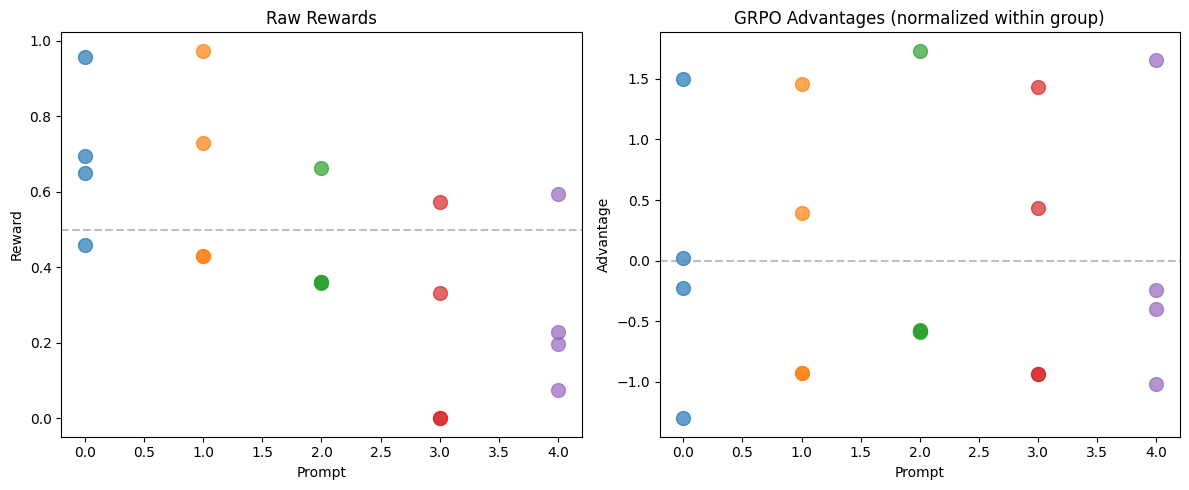

Notice: GRPO advantages are centered at 0 for each group.
This means: no matter the absolute reward level,
we always learn to prefer better completions within the group.


In [6]:
# Visualize group normalization vs. PPO advantage
np.random.seed(42)

# Simulate rewards for 5 prompts, 4 completions each
n_prompts = 5
group_size = 4

all_rewards = np.random.randn(n_prompts, group_size) * 0.3 + 0.5
all_rewards = np.clip(all_rewards, 0, 1)

# GRPO: Normalize within each group
grpo_advantages = np.zeros_like(all_rewards)
for i in range(n_prompts):
    group = all_rewards[i]
    grpo_advantages[i] = (group - group.mean()) / (group.std() + 1e-8)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw rewards
ax = axes[0]
for i in range(n_prompts):
    ax.scatter([i]*group_size, all_rewards[i], s=100, alpha=0.7, label=f'Prompt {i+1}' if i == 0 else '')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Prompt')
ax.set_ylabel('Reward')
ax.set_title('Raw Rewards')

# GRPO advantages
ax = axes[1]
for i in range(n_prompts):
    ax.scatter([i]*group_size, grpo_advantages[i], s=100, alpha=0.7)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Prompt')
ax.set_ylabel('Advantage')
ax.set_title('GRPO Advantages (normalized within group)')

plt.tight_layout()
plt.show()

print("Notice: GRPO advantages are centered at 0 for each group.")
print("This means: no matter the absolute reward level,")
print("we always learn to prefer better completions within the group.")

## DeepSeek-R1: GRPO in Practice

DeepSeek's R1 paper showed remarkable results with GRPO:

1. **R1-Zero**: Trained with pure RL (no SFT), emergent chain-of-thought
2. **R1**: SFT + multi-stage GRPO, matches o1 on benchmarks

Key findings:
- Reasoning behaviors (reflection, backtracking) **emerge from RL alone**
- The "aha moment": model spontaneously discovers better strategies during training
- Distillation works: smaller models can learn R1's reasoning patterns

## Implementing GRPO with TRL

In practice, you'd use the Hugging Face TRL library:

```python
from trl import GRPOTrainer, GRPOConfig

config = GRPOConfig(
    output_dir="./grpo_output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    num_generations=4,  # Group size
    kl_coef=0.1,
)

def reward_function(completions, prompts):
    # Your reward logic here
    return rewards

trainer = GRPOTrainer(
    model=model,
    config=config,
    train_dataset=dataset,
    tokenizer=tokenizer,
    reward_function=reward_function,
)

trainer.train()
```

The key is defining a good reward function. For reasoning, this could be:
- Answer correctness (for math/code)
- A trained reward model
- External verification (running code, checking proofs)

## What We've Learned

GRPO simplifies RLHF for reasoning:

1. **No critic needed** — Use group normalization instead of value function
2. **Group-relative advantages**: $\hat{A}_i = \frac{r_i - \mu_G}{\sigma_G}$
3. **Same clipped objective** as PPO, just different advantage computation
4. **~50% less compute** than PPO

The insight:
> We don't need to predict absolute values. We just need to know which completion is better within each group.

GRPO is particularly powerful for reasoning because:
- Works with verifiable rewards (math correctness, code execution)
- Encourages diverse exploration within groups
- Emergent behaviors arise naturally from RL

**Next up:** Distillation — transferring reasoning abilities to smaller models